In [1]:
import dill
import os
import numpy as np
import jax
import jax.numpy as jnp

# Load true funcitons
ex_name = 'ex4-3D_spd'
file_path = os.path.join("true_functions", f"{ex_name}.pkl")

with open(file_path, "rb") as f:
    loaded_functions = dill.load(f)

true_drift = loaded_functions["drift"]
true_diffusion = loaded_functions["diffusion"]

In [2]:
# training data parameters
n_dimensions = 3
xlim = np.array([[-1, 1], [-1, 1], [-1, 1]])

random_seed = 1
rng = np.random.default_rng(random_seed)

n_trajectories = 10000
trajectory_time = 0.01
step_size = 0.01
grid_resolution = int(trajectory_time/step_size) + 1 # +1 to account for staring point


In [3]:
def simulate_euler_maruyama(key, drift_fn, diffusion_fn, x0, step_size, grid_resolution):
    """
    Simulate trajectories using Euler-Maruyama.
    - x0: (N, D) array of initial positions
    - Returns: x: (N, D, T)
    """
    n_trajectories, n_dimensions = x0.shape
    T = grid_resolution

    # Generate dW: shape (T-1, N, D)
    key, subkey = jax.random.split(key)
    dW = jax.random.normal(subkey, shape=(T-1, n_trajectories, n_dimensions)) * jnp.sqrt(step_size)

    def euler_step(x_t, dW_t):
        drift = drift_fn(x_t)                 # (N, D)
        diffusion = diffusion_fn(x_t)         # (N, D, D)
        diffusion_term = jnp.einsum('nij,nj->ni', diffusion, dW_t)  # (N, D)
        x_next = x_t + drift * step_size + diffusion_term
        return x_next, x_next

    # Run lax.scan
    _, xs = jax.lax.scan(euler_step, x0, dW)
    
    # Add initial condition to beginning
    x_full = jnp.concatenate([x0[:, :, None], xs.transpose(1, 2, 0)], axis=-1)  # (N, D, T)
    return x_full

In [4]:
key = jax.random.PRNGKey(0)
x0 = jax.random.uniform(key, shape=(n_trajectories, n_dimensions), minval=xlim[:,0], maxval=xlim[:,1])

x = simulate_euler_maruyama(
    key,
    drift_fn=true_drift,
    diffusion_fn=true_diffusion,
    x0=x0,
    step_size=step_size,
    grid_resolution=grid_resolution
)

print(x.shape)

(10000, 3, 2)


In [ ]:
# # generate euler-maruyama paths
# x = np.zeros((n_trajectories, n_dimensions, grid_resolution))

# x[:, :, 0] = rng.uniform(low=xlim[:,0], high=xlim[:,1], size=(n_trajectories, n_dimensions))

# dW = rng.normal(loc=0, scale=np.sqrt(step_size), size=(n_trajectories, n_dimension, grid_resolution - 1))

# for i in range(grid_resolution - 1):
#     x[:, :, i+1] = x[:, :, i] + true_drift(x[:, :, i]) * step_size + true_diffusion(x[:, :, i]) * dW[:, :, i]

# print(x.shape)

(9999800, 1)
(9999800, 1)


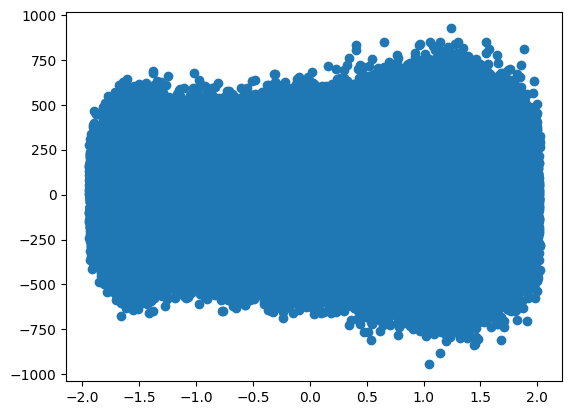

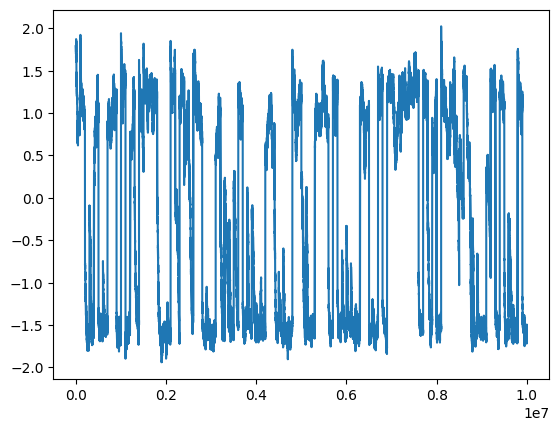

In [8]:
# import matplotlib
# from matplotlib import pyplot as plt

# sampled_x = x[::int(1)]
# # x_data = x[:, :, :-1].reshape(-1, n_dimensions)
# # y_data = x[:, :, 1:].reshape(-1, n_dimensions)
# x_data = sampled_x[:, :, :-1].reshape(-1, n_dimensions)
# y_data = sampled_x[:, :, 1:].reshape(-1, n_dimensions)
# print(x_data.shape)
# print(y_data.shape)

# plt.scatter(x_data, (y_data-x_data)/step_size)
# plt.show()
# plt.plot(x_data)
# plt.show()

In [5]:

np.savez(f"training_data/{ex_name}_time{trajectory_time}_SS{step_size}_ntraj{n_trajectories}.npz", n_dimensions=n_dimensions, step_size=step_size, xlim=xlim, trajectories=np.array(x))
